# Exploratory Data Analysis (EDA)

This notebook explores manufacturing downtime data to find key insights to include in the final dashboard.

# Contents
- [Factors Causing Downtime](#Factors-Causing-Downtime)
    - [Analysis Quesiont 01: Which Factors Contribute The Most to Downtime?](#Analysis-Question-01:-Which-Factors-Contribute-The-Most-to-Downtime?)
    - [Analysis Question 02: Which Downtime Factors Occur More Frequently?](#Analysis-Question-02:-Which-Downtime-Factors-Occur-More-Frequently?)
    - [Analysis Quesion 03: How Much of The Downtime is Associated with Operator Errors?](#Analysis-Quesion-03:-How-Much-of-The-Downtime-is-Associated-with-Operator-Errors?)
    - [Analysis Question 04: Which Operator Causes More Downtime?](#Analysis-Question-04:-Which-Operator-Causes-More-Downtime?)
    - [Analysis Question 05: Does Downtime Occur at Higher Rates for in Products with Certain Flavors?](#Analysis-Question-05:-Does-Downtime-Occur-at-Higher-Rates-for-in-Products-with-Certain-Flavors?)
    - [Analysis Question 06: How Does Product Size Impact The Occurrence of Downtime?](#Analysis-Question-06:-How-Does-Product-Size-Impact-The-Occurrence-of-Downtime?)
    -  [Analysis Question 07: Does Product Size Cause More Downtime Due to Product Spill?](#Analysis-Question-07:-Does-Product-Size-Cause-More-Downtime-Due-to-Product-Spill?)

## Import Packages and Load Data

In [1]:
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Load data
source = "../phase-1/clean_data_final.xlsx"
sheet_names = ["Line_productivity", "Calender", "Products", "Product_details", "Downtime_factors", "Line_downtime"]
tables = pd.read_excel(source, sheet_names)

In [3]:
# Merge data
df = pd.merge(
    left=tables["Line_downtime"],
    right=tables["Line_productivity"],
    how="inner",
    on="Batch"
)

# Merge on Downtime Factors
df = df.merge(
    right=tables["Downtime_factors"],
    how="inner",
    on="Factor"
)

# Merge on Products
df = df.merge(
    right=tables["Products"],
    how="inner",
    on="Product"
)

# Merge on Product Details
df = df.merge(
    right=tables["Product_details"],
    how="inner",
    left_on="Size_In_ml",
    right_on="Size"
).drop(columns="Size_In_ml")

# Merge on Calendar
df = df.merge(
    right=tables["Calender"],
    how="inner",
    on="Date"
)

df.rename(columns=lambda x: x.lower(), inplace=True)
df

,batch,factor,minutes,operator,date,start_time,end_time,product,description,operator_error,flavor,size,min_batch_time,year,month,quarter,week_of_month,day_name,month_name
0,422111,2,60,Mac,2024-08-29,11:50:00,14:05:00,OR-600,Batch change,Yes,Orange,600,60,2024,8,3,5,Thursday,August
1,422111,7,15,Mac,2024-08-29,11:50:00,14:05:00,OR-600,Machine failure,No,Orange,600,60,2024,8,3,5,Thursday,August
2,422112,2,20,Mac,2024-08-29,14:05:00,15:45:00,LE-600,Batch change,Yes,Lemon lime,600,60,2024,8,3,5,Thursday,August
3,422112,8,20,Mac,2024-08-29,14:05:00,15:45:00,LE-600,Batch coding error,Yes,Lemon lime,600,60,2024,8,3,5,Thursday,August
4,422113,2,50,Mac,2024-08-29,15:45:00,17:35:00,LE-600,Batch change,Yes,Lemon lime,600,60,2024,8,3,5,Thursday,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,422147,4,17,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Inventory shortage,No,Cola,2000,98,2024,9,3,1,Monday,September
57,422147,6,60,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Machine adjustment,Yes,Cola,2000,98,2024,9,3,1,Monday,September
58,422147,7,30,Charlie,2024-09-02,19:30:00,22:55:00,CO-2000,Machine failure,No,Cola,2000,98,2024,9,3,1,Monday,September
59,422148,4,25,Mac,2024-09-03,22:55:00,01:05:00,CO-2000,Inventory shortage,No,Cola,2000,98,2024,9,3,1,Tuesday,September


## Factors Causing Downtime

#### Analysis Question 01: Which Factors Contribute The Most to Downtime?

In [4]:
# Group data for chart
pareto_df = df.groupby(["description"], as_index=False).agg({
    "minutes": "sum"
})
pareto_df.sort_values(by="minutes", ascending=False, inplace=True, ignore_index=True)
pareto_df["percent"] = round(pareto_df["minutes"] * 100 / pareto_df["minutes"].sum(), 2)
pareto_df["cum_percent"] = round(pareto_df["minutes"].cumsum() * 100 / pareto_df["minutes"].sum(), 2)

# Show data
pareto_df

,description,minutes,percent,cum_percent
0,Machine adjustment,332,23.92,23.92
1,Machine failure,254,18.30,42.22
2,Inventory shortage,225,16.21,58.43
3,Batch change,160,11.53,69.96
4,Batch coding error,145,10.45,80.40
5,Other,74,5.33,85.73
6,Product spill,57,4.11,89.84
7,Calibration error,49,3.53,93.37
8,Labeling error,42,3.03,96.40
9,Label switch,33,2.38,98.78


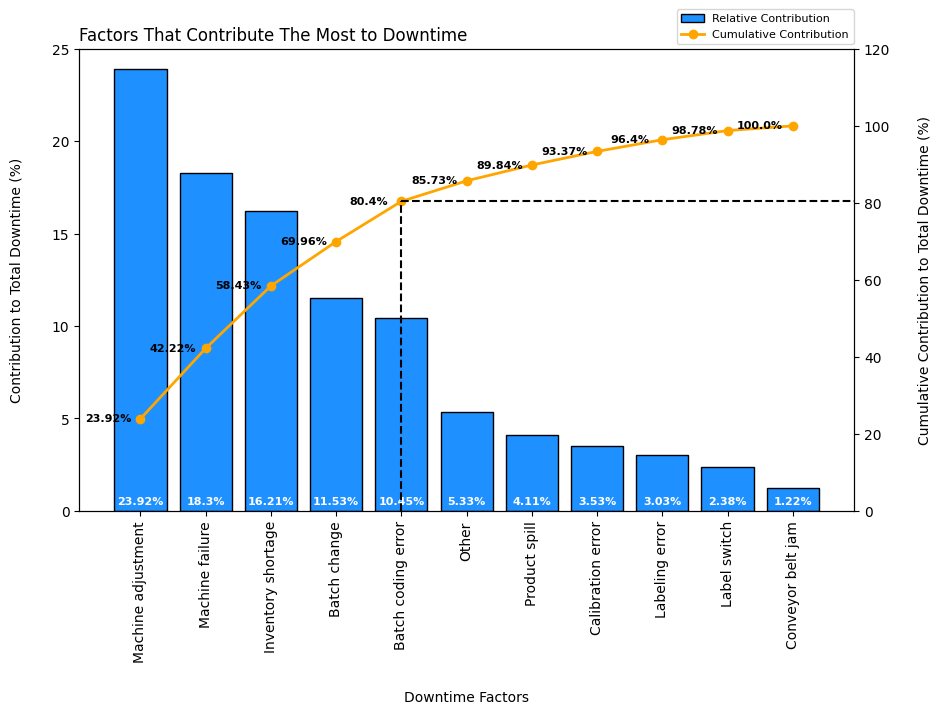

In [5]:
# Plot diagram
fig, ax_bar = plt.subplots(figsize=(10, 6))

xticks = np.arange(len(pareto_df))

# Plot the bar chart
bars = ax_bar.bar(
    x=xticks,
    height=pareto_df["percent"],
    color="dodgerblue",
    edgecolor="black",
    label="Relative Contribution",
    zorder=0
)
ax_bar.set_xticks(xticks)
ax_bar.set_xticklabels(pareto_df["description"], rotation=90)
ax_bar.set_ylabel("Contribution to Total Downtime (%)", labelpad=20)
ax_bar.set_xlabel("Downtime Factors", labelpad=20)
ax_bar.set_title("Factors That Contribute The Most to Downtime", ha="left", x=0)
ax_bar.set_ylim(0, np.ceil(pareto_df.loc[0, "percent"] / 5) * 5)

# Plot the line
ax_line = ax_bar.twinx()
line = ax_line.plot(
    xticks,
    pareto_df["cum_percent"],
    label="Cumulative Contribution",
    color="orange",
    marker="o",
    lw=2,
    zorder=1
)
ax_line.set_ylabel("Cumulative Contribution to Total Downtime (%)", labelpad=20)
ax_line.set_ylim(0, 120)

# Draw dashed line at 80%
x = pareto_df[pareto_df["cum_percent"] >= 80].index[0]
y = pareto_df.loc[x, "cum_percent"]
line_v = Line2D((x, x), (0, y), color="black", ls="--", zorder=2)
line_h = Line2D((x, xticks.max() + 1), (y, y), color="black", ls="--", zorder=2)
ax_line.add_line(line_v)
ax_line.add_line(line_h)

# Add labels
for i in xticks:
    ax_bar.text(i, 0.5, f"{pareto_df.iloc[i, 2]}%", 
                color="white", fontsize=8, fontweight="bold", ha="center", va="center", zorder=3)
    ax_line.text(i - 0.5, pareto_df.loc[i, "cum_percent"], f"{pareto_df.iloc[i, 3]}%", 
                 fontsize=8, fontweight="bold", ha="center", va="center", zorder=3)

# Show legend
fig.legend(bbox_to_anchor=(0.905, 0.955), fontsize=8)

plt.show()

#### Analysis Question 02: Which Downtime Factors Occur More Frequently?

In [6]:
# Group data for chart
factor_dist_df = df.groupby(["description"], as_index=False).agg({"factor":"count"})
factor_dist_df.sort_values(by="factor", ascending=False, ignore_index=True, inplace=True)
factor_dist_df.rename(columns={"description": "factor", "factor":"freq"}, inplace=True)
total = factor_dist_df["freq"].sum()
factor_dist_df["relative_freq"] = round(factor_dist_df["freq"] * 100 / total, 2)

# Show data
factor_dist_df

,factor,freq,relative_freq
0,Machine adjustment,12,19.67
1,Machine failure,11,18.03
2,Inventory shortage,9,14.75
3,Batch coding error,6,9.84
4,Other,6,9.84
5,Batch change,5,8.20
6,Calibration error,3,4.92
7,Label switch,3,4.92
8,Product spill,3,4.92
9,Labeling error,2,3.28


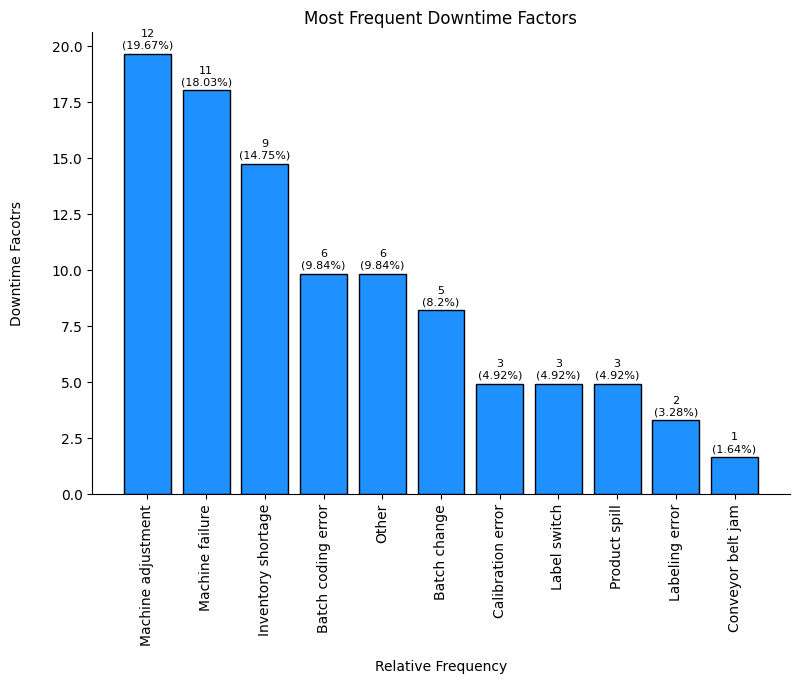

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot bars
x = np.arange(len(factor_dist_df))
bars = ax.bar(x, factor_dist_df["relative_freq"], color="dodgerblue", edgecolor="black")
ax.set_xticks(x)
ax.set_xticklabels(factor_dist_df["factor"], rotation=90)
ax.set_xlabel("Relative Frequency", labelpad=10)
ax.set_ylabel("Downtime Facotrs", labelpad=20)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Most Frequent Downtime Factors")

# Add labels
for x in xticks:
    ax.text(x, bars[x].get_height() + 0.25, f"{factor_dist_df.loc[x, 'freq']}\n({factor_dist_df.loc[x, 'relative_freq']}%)", fontsize=8, ha="center")

plt.show()

#### Analysis Quesion 03: How Much of The Downtime is Associated with Operator Errors?

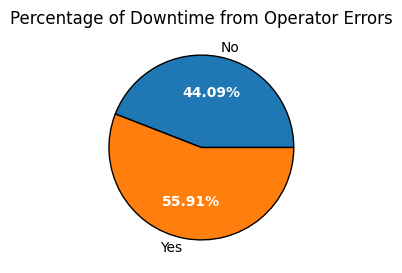

In [8]:
# Group data for chart
pie_df = df.groupby(["operator_error"], as_index=False).agg({"minutes":"sum"})

# Plot pie
fig, ax = plt.subplots(figsize=(5, 3))

wedges, texts, autotexts = ax.pie(pie_df["minutes"], labels=pie_df["operator_error"], autopct="%0.2f%%",
      wedgeprops={"edgecolor":"black"})
ax.set_title("Percentage of Downtime from Operator Errors")

for text in autotexts:
    text.set_color("white")
    text.set_weight("bold")

plt.show()

#### Analysis Question 04: Which Operator Causes More Downtime?

In [9]:
# Group data for chart
operator_downtime = df[df["operator_error"] == "Yes"].groupby("operator", as_index=False)["minutes"].sum()
operator_downtime = operator_downtime.sort_values(by="minutes", ascending=False, ignore_index=True)
operator_downtime["minutes"] = operator_downtime["minutes"].round(2)

# Show data
operator_downtime

,operator,minutes
0,Charlie,228
1,Dee,192
2,Mac,192
3,Dennis,164


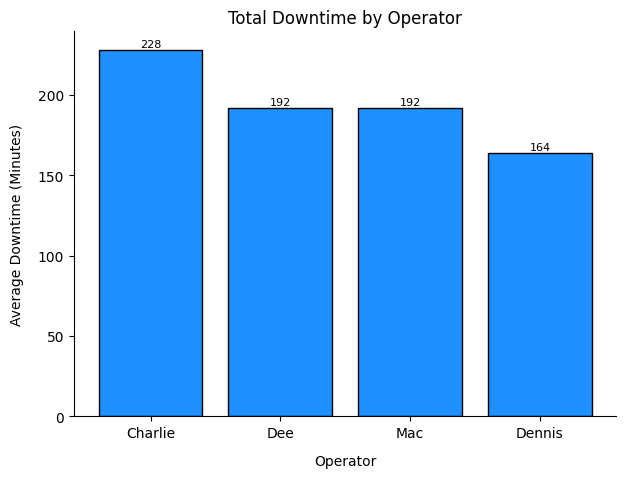

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the chart
x = np.arange(len(operator_downtime))
ax.bar(x, operator_downtime["minutes"], color="dodgerblue", edgecolor="black")
ax.set_xticks(x)
ax.set_xticklabels(operator_downtime["operator"])
ax.set_xlabel("Operator", labelpad=10)
ax.set_ylabel("Average Downtime (Minutes)", labelpad=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total Downtime by Operator")

# Add data labels
for i in x:
    ax.text(i, operator_downtime.loc[i, "minutes"] + 1.5, f"{operator_downtime.loc[i, 'minutes']}",
           fontsize=8, ha="center")

plt.show()

#### Analysis Question 05: Does Downtime Occur at Higher Rates for in Products with Certain Flavors?

In [13]:
# Group data
flavor_aggregated_df = df.groupby("flavor", as_index=False)["minutes"].sum().sort_values(by="minutes", ascending=False, ignore_index=True)
flavor_aggregated_df["minutes"] = flavor_aggregated_df["minutes"].round(2)
flavor_aggregated_df

,flavor,minutes
0,Cola,771
1,Root Berry,258
2,Lemon lime,169
3,Diet Cola,115
4,Orange,75


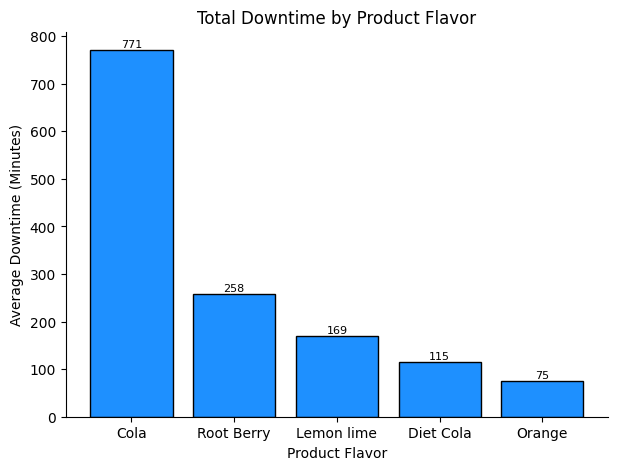

In [17]:
fig, ax = plt.subplots(figsize=(7, 5))

xticks = np.arange(len(flavor_aggregated_df))
ax.bar(xticks, flavor_aggregated_df["minutes"], color="dodgerblue", edgecolor="black")
ax.set_xticks(xticks)
ax.set_xticklabels(flavor_aggregated_df["flavor"])
ax.set_xlabel("Product Flavor")
ax.set_ylabel("Average Downtime (Minutes)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total Downtime by Product Flavor")

for x in xticks:
    ax.text(x, flavor_aggregated_df.loc[x, "minutes"] + 5.5, f"{flavor_aggregated_df.loc[x, 'minutes']}", fontsize=8, ha="center")

plt.show()

#### Analysis Question 06: How Does Product Size Impact The Occurrence of Downtime?

In [19]:
prod_size_aggregated_df = df.groupby("size", as_index=False)["minutes"].sum()
prod_size_aggregated_df["size"] = prod_size_aggregated_df["size"].astype(str) + " ml"
prod_size_aggregated_df["minutes"] = prod_size_aggregated_df["minutes"].round(2)
prod_size_aggregated_df

,size,minutes
0,600 ml,1111
1,2000 ml,277


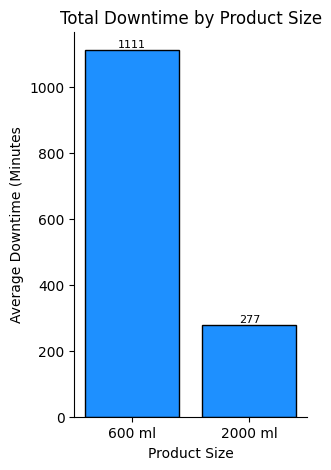

In [22]:
fig, ax = plt.subplots(figsize=(3, 5))

xticks = np.arange(len(prod_size_aggregated_df))
ax.bar(xticks, prod_size_aggregated_df["minutes"], color="dodgerblue", edgecolor="black")
ax.set_xticks(xticks)
ax.set_xticklabels(prod_size_aggregated_df["size"])
ax.set_xlabel("Product Size")
ax.set_ylabel("Average Downtime (Minutes")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total Downtime by Product Size")

for x in xticks:
    ax.text(x, prod_size_aggregated_df.loc[x, "minutes"] + 7.5, f"{prod_size_aggregated_df.loc[x, 'minutes']}", fontsize=8, ha="center")

plt.show()

#### Analysis Question 07: Does Product Size Cause More Downtime Due to Product Spill?

In [23]:
# What is the relation between product spill and product size?
aggregated_df = df[df["factor"] == 5].groupby("size", as_index=False)["minutes"].sum()
aggregated_df["size"] = aggregated_df["size"].astype(str) + " ml"
aggregated_df["minutes"] = aggregated_df["minutes"].round(2)
aggregated_df

,size,minutes
0,600 ml,57
